Since 2008, guests and hosts have used Airbnb to expand on traveling possibilities and present a more unique, personalized way of experiencing the world. Today, Airbnb became one of a kind service that is used and recognized by the whole world.

XGBOOST and Deep neural networks will be used to predict Airbnb's rental prices in the New York area through various machine learning models.


In [ ]:
#importing necessery libraries for future analysis of the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
import time
import plotly.express as px
import tensorflow as tf
import keras
from numpy.random import seed
from pprint import pprint
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor


Mounted at /content/drive


In [ ]:
#using pandas library and 'read_csv' function to read BlackFriday csv file as file already formated for us from Kaggle
# original path
dataset_path = 'AB_NYC_2019.csv'
raw_data=pd.read_csv(dataset_path)

airbnb = (raw_data[raw_data['price'] != 0]
    .drop(['id','host_name','last_review'], axis=1)
    .assign(number_of_reviews=raw_data.number_of_reviews.fillna(0.0))
    .assign(reviews_per_month=raw_data.reviews_per_month.fillna(0.0))
    .dropna(how="any")
    .reset_index(drop=True)
)

Here is the variable table explaining the columns in the original dataset:

| Column Name                       | Type    | Description                                                                                     |
|-----------------------------------|---------|-------------------------------------------------------------------------------------------------|
| name                              | object  | The listing's title or name, as provided by the host.                                           |
| host_id                           | int64   | The unique identifier for the host of the listing.                                              |
| neighbourhood_group               | object  | The broader region or borough where the listing is located.                                     |
| neighbourhood                     | object  | The specific area or community within the neighbourhood group where the listing is located.     |
| latitude                          | float64 | The geographical latitude where the listing is situated.                                         |
| longitude                         | float64 | The geographical longitude where the listing is situated.                                        |
| room_type                         | object  | The type of room being offered (e.g., Entire home/apt, Private room, Shared room).              |
| price                             | int64   | The cost per night for the listing.                                                              |
| minimum_nights                    | int64   | The minimum number of nights a guest must stay when booking the listing.                         |
| number_of_reviews                 | int64   | The total number of reviews that the listing has received.                                       |
| reviews_per_month                 | float64 | The average number of reviews the listing receives per month.                                    |
| calculated_host_listings_count    | int64   | The total number of listings that the host has across Airbnb.                                    |
| availability_365                  | int64   | The number of days in a year that the listing is available for booking.                          |
| geo_cluster                       | int32   | A derived numerical value, possibly categorizing listings into geographical clusters or groups. |


# EDA

## price distribution
The cost per night for Airbnb listings has the following characteristics based on the descriptive statistics provided:

- **High Variability**: The high standard deviation is rational considering the diverse types of listings on Airbnb, from shared rooms to luxury villas. This would naturally lead to a wide range of prices.
  
- **Price Skewness**: It is also reasonable for the distribution to be right-skewed because the majority of listings are likely to be standard accommodations, while a smaller number of luxury or unique listings will have very high prices, pulling the average up.

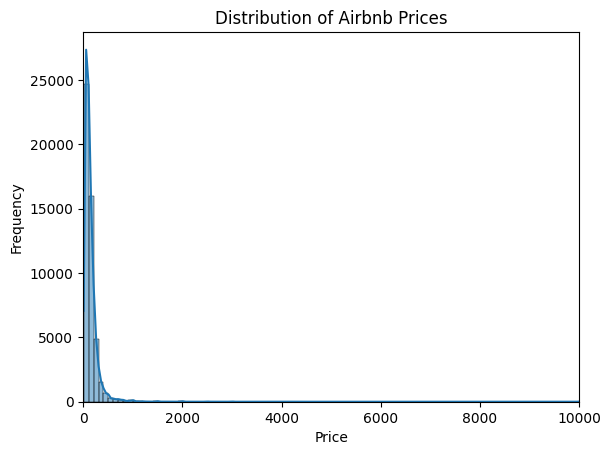

In [ ]:
sns.histplot(airbnb['price'],bins=100,kde=True)
plt.xlim(0, max(airbnb['price']))

# Optionally, you can add labels and a title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Airbnb Prices')

# Show the plot
plt.show()

## longitude & latitude : distribution visualization

- In the New York area, it can be observed that the distribution of listings predominantly shows fewer in the west and more in the east.
- Listings with high prices are mainly concentrated in the central and western parts of New York, while there is a sparse distribution of listings in the southwest with relatively lower prices.
- These encourage further clustering analysis.

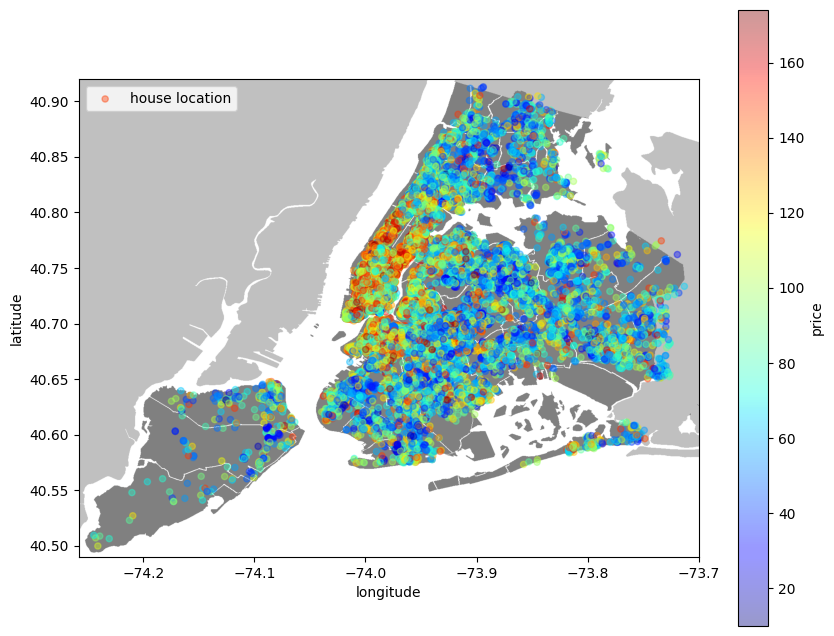

In [ ]:
import urllib
#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
response = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
image_data = response.read()
from io import BytesIO
image_stream = BytesIO(image_data)
nyc_img = plt.imread(image_stream)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
#using scatterplot again
sub_6=airbnb[airbnb.price < airbnb.price.quantile(0.75)]
sub_6.plot(kind='scatter', x='longitude', y='latitude', label='house location', c='price', ax=ax,
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)

plt.legend()
plt.show()

## number_of_reviews : 10 most reviewed listings
Observing the top 10 listings with the highest number of reviews on Airbnb, we can derive several conclusions or findings:

1. **Affordability**: The majority of these listings are priced reasonably, with many under $50 per night, which could be a factor contributing to their popularity. The affordability of these listings makes them attractive options for travelers on a budget.

2. **Private Room Dominance**: Most of the top-reviewed listings are for private rooms rather than entire homes or apartments. This preference indicates that guests may prioritize affordability and location over having an entire place to themselves.

3. **High Availability**: These listings have a relatively high availability throughout the year, with many available for over 200 days. This suggests that hosts are actively managing their listings to accommodate as many guests as possible.

4. **Proximity to Airports**: Some of the listings explicitly mention proximity to major airports (JFK and LaGuardia), highlighting that convenience and ease of access to transportation are significant factors for guests.

This indicates that the relationship between the number of reviews and price is not a simple linear correlation, but rather a relatively complex nonlinear relationship. We hope to further explore this using various machine learning models.


In [ ]:
top_reviewed_listings=airbnb.nlargest(10,'number_of_reviews')
top_reviewed_listings.reset_index(drop=True)

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Room near JFK Queen Bed,47621202,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,14.58,2,333
1,Great Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,7.75,3,293
2,Beautiful Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,7.72,3,342
3,Private Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,7.57,3,339
4,Room Near JFK Twin Beds,47621202,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,13.40,2,173
5,Steps away from Laguardia airport,37312959,Queens,East Elmhurst,40.77006,-73.87683,Private room,46,1,543,11.59,5,163
6,Manhattan Lux Loft.Like.Love.Lots.Look !,2369681,Manhattan,Lower East Side,40.71921,-73.99116,Private room,99,2,540,6.95,1,179
7,Cozy Room Family Home LGA Airport NO CLEANING FEE,26432133,Queens,East Elmhurst,40.76335,-73.87007,Private room,48,1,510,16.22,5,341
8,Private brownstone studio Brooklyn,12949460,Brooklyn,Park Slope,40.67926,-73.97711,Entire home/apt,160,1,488,8.14,1,269
9,LG Private Room/Family Friendly,792159,Brooklyn,Bushwick,40.70283,-73.92131,Private room,60,3,480,6.70,1,0


# Feature Engineering (Including Unsupervised learning)

## Geographic Clustering: K-means for Geographic Clustering in Airbnb Context


- Utilizing K-means for 8 clusters.
- Provides a more human-understandable conceptual framework.


- Based on EDA findings, we employed K-means clustering to cluster latitude and longitude coordinates.
- This approach aims to provide a more human-understandable conceptual framework for subsequent modeling.

**Overview of K-means Algorithm:**
1. Initialization: Select 'k' points as initial centroids.
2. Assignment: Assign each listing (based on latitude and longitude) to the nearest centroid.
3. Update: Recalculate centroids as the mean of all listings in each cluster.
4. Repeat: Continue until centroids stabilize or meet other stopping criteria.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


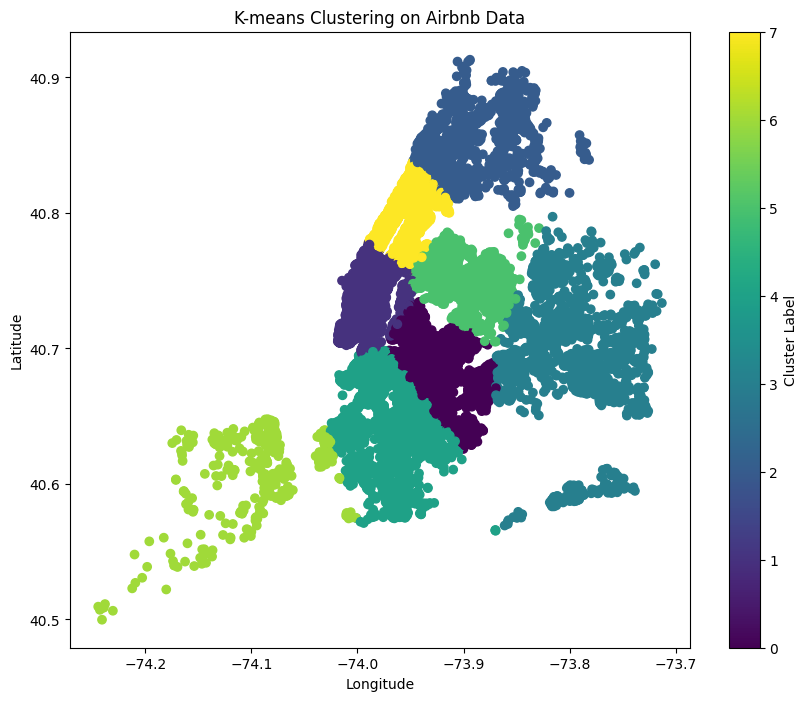

In [ ]:
# Import necessary libraries
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# Determine the number of clusters `K`
K = 8  # Best Suited the actual geo-distribution

# Create an instance of KMeans
kmeans = KMeans(n_clusters=K)

# Perform clustering on the latitude and longitude data
kmeans.fit(airbnb[['latitude', 'longitude']])

# Add the cluster labels as a new feature to the DataFrame
airbnb['geo_cluster'] = kmeans.labels_

# Visualize the clustering results
plt.figure(figsize=(10, 8))
plt.scatter(airbnb['longitude'], airbnb['latitude'], c=airbnb['geo_cluster'], cmap='viridis')
plt.title('K-means Clustering on Airbnb Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster Label')
plt.show()

## Basic Transformation for Text Features

1. **Label Encoding (for 'host_id', 'neighbourhood_group', 'room_type', 'neighbourhood')**
2. **Sentiment Analysis (for 'name')**

1. Label Encoding (for 'host_id', 'neighbourhood_group', 'room_type', 'neighbourhood'):
   - Converts categorical variables into integer codes, avoiding dimensionality issues associated with one-hot encoding for variables with numerous categories.
   - Especially useful when dealing with a large number of unique categories, as one-hot encoding can significantly increase dataset dimensionality.
2. Sentiment Analysis (for 'name'):
   - Applies sentiment analysis to the 'name' column to extract emotional tones of listing names, potentially impacting guest perception.
   - Utilizes TextBlob, a text processing library, to evaluate sentiment and assign polarity scores ranging from -1 (most negative) to 1 (most positive), with 0 indicating neutrality.
   - Helps understand how listing name wording could influence listing appeal to potential guests.

The sentiment scores align well with the descriptive nature of listing names. Positive and inviting descriptions generally yield higher scores, while simpler or neutral names tend to have scores closer to zero.

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob


# Applying Label Encoding to categorical columns to avoid high dimensionality caused by one-hot encoding
label_encoder_host_id = LabelEncoder()
label_encoder_neighbourhood_group = LabelEncoder()
label_encoder_neighbourhood = LabelEncoder()
label_encoder_room_type = LabelEncoder()

# Fit the encoders and transform the columns to integer labels to handle many unique categories efficiently
airbnb['host_id_encoded'] = label_encoder_host_id.fit_transform(airbnb['host_id'])
airbnb['neighbourhood_group_encoded'] = label_encoder_neighbourhood_group.fit_transform(airbnb['neighbourhood_group'])
airbnb['neighbourhood_encoded'] = label_encoder_neighbourhood.fit_transform(airbnb['neighbourhood'])
airbnb['room_type_encoded'] = label_encoder_room_type.fit_transform(airbnb['room_type'])

# Fill missing values with an empty string
airbnb['name'].fillna('', inplace=True)

# Perform sentiment analysis on the 'name' column and store the results in 'name_sentiment'
airbnb['name_sentiment'] = airbnb['name'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
airbnb[['name', 'name_sentiment']]

,name,name_sentiment
0,Clean & quiet apt home by the park,0.322222
1,Skylit Midtown Castle,0.000000
2,THE VILLAGE OF HARLEM....NEW YORK !,0.000000
3,Cozy Entire Floor of Brownstone,-0.100000
4,Entire Apt: Spacious Studio/Loft by central park,0.200000
...,...,...
48863,Charming one bedroom - newly renovated rowhouse,0.418182
48864,Affordable room in Bushwick/East Williamsburg,0.000000
48865,Sunny Studio at Historical Neighborhood,0.000000
48866,43rd St. Time Square-cozy single bed,-0.071429


In [ ]:
# Drop the original columns that were transformed
airbnb.drop(['name','host_id', 'neighbourhood_group', 'room_type', 'neighbourhood'], axis=1, inplace=True)

# Further Cleaning

- **Split the Dataset**

- **Handle Outliers**

- **Feature Scaling**

- **Consistent Preprocessing**




After the feature engineering process, the Airbnb dataset has been enhanced and now comprises the following characteristics:

- **Total Entries**: The dataset encapsulates information on 48,895 listings in New York City.
- **Features**: There are 17 distinct features for each listing after feature engineering.

## Data Splitting and Preprocessing

- **Split the Dataset**: Divide the dataset into training and testing sets to separate the data used for learning from the data used for model evaluation.
  
- **Handle Outliers**: Apply capping to numerical features' outliers by setting them to predefined lower and upper percentiles to reduce their impact without removing them entirely.

- **Feature Scaling**: Standardize numerical features to have zero mean and unit variance to ensure all features contribute equally to the model's performance.

- **Consistent Preprocessing**: Ensure that the same preprocessing steps (outlier handling and scaling) are applied to both training and testing sets to maintain the integrity of the model evaluation.

In [ ]:
# Splitting the dataset first
X = airbnb.drop('price', axis=1)  # Features exclude the target 'price'
y = np.log(airbnb['price'])               # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Defining a function to handle outliers
def cap_outliers(series, lower_percentile=20, upper_percentile=80):
    lower_limit = np.percentile(series, lower_percentile)
    upper_limit = np.percentile(series, upper_percentile)
    series_capped = np.where(series < lower_limit, lower_limit, series)
    series_capped = np.where(series_capped > upper_limit, upper_limit, series_capped)
    return series_capped

# Applying the same outlier handling and standardization to both training and testing sets
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

# Handling outliers
for feature in numerical_features:
    X_train[feature] = cap_outliers(X_train[feature])
    X_test[feature] = cap_outliers(X_test[feature])

# Standardizing numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Now X_train and X_test are ready for model training and evaluation
print(f'Training set: {X_train.shape[0]} listings')
print(f'Testing set: {X_test.shape[0]} listings')

Training set: 34207 listings
Testing set: 14661 listings


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48868 entries, 0 to 48867
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48868 non-null  float64
 1   longitude                       48868 non-null  float64
 2   minimum_nights                  48868 non-null  int64  
 3   number_of_reviews               48868 non-null  int64  
 4   reviews_per_month               48868 non-null  float64
 5   calculated_host_listings_count  48868 non-null  int64  
 6   availability_365                48868 non-null  int64  
 7   geo_cluster                     48868 non-null  int32  
 8   host_id_encoded                 48868 non-null  int64  
 9   neighbourhood_group_encoded     48868 non-null  int64  
 10  neighbourhood_encoded           48868 non-null  int64  
 11  room_type_encoded               48868 non-null  int64  
 12  name_sentiment                  

In [ ]:
def getPerformMetrix(y_train, y_train_pred, y_test, y_test_pred):
    metrics = {
        'MSE': [mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)],
        'RMSE': [np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_test_pred))],
        'MAE': [mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)],
        'R^2': [r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)]
    }

    metrics_df = pd.DataFrame(metrics, index=['In-Sample', 'Out-of-Sample'])

    return metrics_df

In [ ]:
def plot_predictions(y_train, y_train_pred, y_test, y_test_pred):

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # 绘制y=x线
    plt.title('Training set: Actual vs. Predicted')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='red')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 绘制y=x线
    plt.title('Test set: Actual vs. Predicted')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_train_history(hist):
    '''Converts training history into a DataFrame and plots training and validation loss.
    Handles cases where validation data might not be present.'''
    # Convert history into a DataFrame
    history_df = pd.DataFrame(hist.history)
    history_df['epoch'] = history_df.index + 1

    # Plot configuration
    fig = px.line()
    fig.add_scatter(x=history_df['epoch'], y=history_df['loss'], name='Training Loss', mode='lines+markers')

    # Check if validation loss is present in the history
    if 'val_loss' in history_df.columns:
        fig.add_scatter(x=history_df['epoch'], y=history_df['val_loss'], name='Validation Loss', mode='lines+markers')

    # Update plot layout
    fig.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epoch',
                      yaxis_title='Loss',
                      legend_title='Type')
    return fig

# Model Building:  XGBOOST

- Employ XGBoost Regressor: Constructs an ensemble of decision trees sequentially, with each tree aimed at rectifying errors from prior ones.
- Aids in mitigating overfitting and managing sparse data.
- Two features with the lowest importance were filtered out using feature_importances. Six hyperparameters including the number of estimators and max_depth were adjusted via random search and 3-fold cross-validation.

In [ ]:
# Initialize XGBoost regressor
params = {
    'objective': 'reg:squarederror',
    'colsample_bytree': 0.3,
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'n_estimators': 200
}

xg_reg = xgb.XGBRegressor(**params)
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set
y_test_xg_original = xg_reg.predict(X_test)
y_train_xg_original = xg_reg.predict(X_train)

In [ ]:
selection = SelectFromModel(xg_reg, threshold=0.008, prefit=True)
X_train_reduced = selection.transform(X_train)
X_test_reduced = selection.transform(X_test)

xg_reg_reduced = xgb.XGBRegressor(**params)

xg_reg_reduced.fit(X_train_reduced, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# Parameter distribution for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [6, 7, 8],
    'alpha': [0,1,2],
    'lambda': [8,10,12], # L2 regularization term on weights
    'subsample': [0.75, 0.8, 0.85], # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(scoring='r2',estimator=xg_reg_reduced, param_distributions=param_dist, n_iter=200, cv=3, verbose=3, n_jobs=-1, random_state=42)

# Assuming X_train_reduced, y_train, X_test_reduced, y_test are defined and ready
random_search.fit(X_train_reduced, y_train)

xg_reg_revs = random_search.best_estimator_

# Print the best parameters
print("Best Estimators of Random Search: ", random_search.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Best Estimators of Random Search:  {'subsample': 0.85, 'max_depth': 8, 'learning_rate': 0.05, 'lambda': 8, 'colsample_bytree': 0.8, 'alpha': 1}


In [2]:
search_best_params = {'subsample': 0.8, 'max_depth': 8, 'learning_rate': 0.05, 'lambda': 12, 'colsample_bytree': 0.6, 'alpha': 0}
# search_best_params = random_search.best_params_
params.update(search_best_params)

xg_reg_revs = xgb.XGBRegressor(**params)
xg_reg_revs.fit(X_train_reduced, y_train)

pm_matrix_xg = getPerformMetrix(y_train, xg_reg_revs.predict(X_train_reduced), y_test, xg_reg_revs.predict(X_test_reduced)).assign(model="XGBoost")
pm_matrix_xg

NameError: name 'params' is not defined

# Model Building: Deep Neural Network

Our study developed an advanced Deep Neural Network (DNN) to predict Airbnb prices, leveraging the Rectified Linear Unit (ReLU) activation function, L1 and L2 regularization, and a 10% dropout rate to enhance performance and prevent overfitting. Batch normalization after each activation and extensive hyperparameter trials further refined the model's efficiency. Early stopping monitored training to ensure optimal learning without overfitting, and performance was evaluated using mean squared error (MSE), demonstrating the model's accuracy and generalizability in predicting Airbnb prices, rivaling the benchmark XGBoost model without overfitting, thus showcasing its potential as a powerful tool in real estate analytics.

In [ ]:
# Separate features and target variables
X = airbnb.drop('price', axis=1)
y = np.log(airbnb['price'])

# Split the data set into training set and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(496)

# Regularization strength
l1_rate = 0.00015
l2_rate = 0.00015


# # Modify the model to include Batch Normalization and L1/L2 regularization
model = Sequential()
model.add(Dense(512, input_dim=X_train_scaled.shape[1], activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())  # Adding Batch Normalization after the first Dense layer
model.add(Dropout(0.1))  # Adding dropout with a rate of 0.1
model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))
model.add(BatchNormalization())  # Adding Batch Normalization
model.add(Dropout(0.1))  # Adding another dropout layer
model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate)))  # Reducing the complexity a bit
model.add(Dense(1, activation='linear'))

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               7168      
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [ ]:
# Compile the model with suitable loss function for regression
model.compile(loss='mean_squared_error', optimizer='adam')
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
num_epochs = 500
#print("Training model for", num_epochs, "epochs")
start = time.time()

# Fit the model on the scaled data
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=num_epochs, batch_size=256, verbose=0, callbacks=[early_stopping])

end = time.time()
#print("Training the model took", np.round(end - start), "s")

#plot_train_history(history).show()
train_predictions = model.predict(X_train_scaled, verbose=0)
predictions = model.predict(X_test_scaled, verbose=0)

# Calculate performance metrics

performance_metrics = getPerformMetrix(y_train, train_predictions, y_test, predictions)
# plot_predictions(y_train, train_predictions, y_test, predictions)
print(performance_metrics)

                    MSE      RMSE       MAE       R^2
In-Sample      0.190492  0.436454  0.310647  0.611194
Out-of-Sample  0.193243  0.439594  0.317428  0.598957


# Model Building: Self-Attention Neural Network


Beyond DNNs, we're exploring innovative models for our complex Airbnb dataset, as traditional architectures like CNNs and RNNs don't suit tabular data without spatial or temporal patterns. We've turned to self-attention mechanisms, particularly through MultiHeadAttention layers, to address this challenge. These mechanisms, central to Transformer models, dynamically focus on the most relevant features, offering a novel approach for tabular data. Our Lightweight Self-Attention Neural Network leverages Self-Attention and Multi-Head Attention to prioritize crucial data points and understand feature interactions, enhancing predictive accuracy. Despite using only a fraction of the parameters compared to our DNN model, this approach achieves comparable performance metrics, demonstrating its efficiency and effectiveness in modeling complex relationships within tabular data, making it a promising tool for predictive analytics.

In [ ]:
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

def create_self_attention_model(input_shape, embed_dim, num_heads, ff_dim, dropout_rate, l1_rate, l2_rate):
    inputs = Input(shape=(input_shape,))
    x = tf.expand_dims(inputs, axis=1)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = Flatten()(attention_output)
    x = Dense(ff_dim, activation="relu", kernel_regularizer=l1_l2(l1=l1_rate, l2=l2_rate))(x)
    #x = BatchNormalization()(x)
    #x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Model hyperparameters (adjust as needed)
embed_dim = 64  # Embedding size for attention
num_heads = 4 # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.2
l1_rate = 0.0001
l2_rate = 0.0001

# Create the model
model = create_self_attention_model(X_train_scaled.shape[1], embed_dim, num_heads, ff_dim, dropout_rate, l1_rate, l2_rate)

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 13)]                 0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 1, 13)                0         ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 multi_head_attention (Mult  (None, 1, 13)                14093     ['tf.expand_dims[0][0]',      
 iHeadAttention)                                                     'tf.expand_dims[0][0]']      
                                                                                              

In [ ]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=256,
    verbose=0,
    callbacks=[early_stopping]
)

# Plot training history
# plot_train_history(history).show()

# Make predictions
train_predictions = model.predict(X_train_scaled, verbose=0)
test_predictions = model.predict(X_test_scaled,verbose=0)

# Evaluate the model
performance_metrics = getPerformMetrix(y_train, train_predictions.flatten(), y_test, test_predictions.flatten())
print(performance_metrics)

                    MSE      RMSE       MAE       R^2
In-Sample      0.205907  0.453770  0.323777  0.579730
Out-of-Sample  0.204110  0.451786  0.326312  0.576403


In [ ]:
# from sklearn.base import BaseEstimator, RegressorMixin
# from sklearn.model_selection import GridSearchCV
# # This is the grid search that discover the optimal code for the self attention model
# # Custom scikit-learn estimator for a Keras model
# class KerasGridSearchModel(BaseEstimator, RegressorMixin):
#     def __init__(self, num_heads=2, embed_dim=64, ff_dim=256, dropout_rate=0.1, l1_rate=0.0001, l2_rate=0.0001):
#         # Initialize the hyperparameters
#         self.num_heads = num_heads
#         self.embed_dim = embed_dim
#         self.ff_dim = ff_dim
#         self.dropout_rate = dropout_rate
#         self.l1_rate = l1_rate
#         self.l2_rate = l2_rate
#         # Initialize the model (to be created when fitting)
#         self.model = None

#     def fit(self, X, y):
#         # Create the Keras model (using your existing function)
#         self.model = create_self_attention_model(
#             input_shape=X.shape[1],
#             embed_dim=self.embed_dim,
#             num_heads=self.num_heads,
#             ff_dim=self.ff_dim,
#             dropout_rate=self.dropout_rate,
#             l1_rate=self.l1_rate,
#             l2_rate=self.l2_rate
#         )
#         # Compile the model
#         self.model.compile(optimizer="adam", loss="mean_squared_error")
#         # Fit the model
#         self.model.fit(X, y, epochs=100, batch_size=256, verbose=0)
#         return self

#     def predict(self, X):
#         # Use the model to make predictions
#         preds = self.model.predict(X)
#         return np.squeeze(preds)

# # Define the grid search parameters
# param_grid = {
#     'num_heads': [1, 2, 4],
#     'embed_dim': [64, 128],
#     'ff_dim': [128, 256],
#     'dropout_rate': [0.1, 0.2],
#     'l1_rate': [0.0001, 0.001],
#     'l2_rate': [0.0001, 0.001]
# }

# # Create the GridSearchCV object with the custom estimator
# grid = GridSearchCV(estimator=KerasGridSearchModel(), param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train_scaled, y_train)

# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Conclusion

Mean Absolute Error is a metric used to measure the accuracy of a model in regression analysis. It calculates the average magnitude of the errors between the predicted values and the actual values, without considering their direction. Lower MAE values indicate a model with better predictive accuracy, as it means the predicted values are closer to the actual values.

- Among the evaluated models, **XGBoost** exhibits the lowest MAE for both in-sample and out-of-sample predictions, signifying its superior predictive accuracy compared to the other models.
- The ranking of models by MAE closely mirrors the observations made with R-squared and RMSE metrics, where XGBoost also outperformed other models. This consistency across different evaluation metrics further validates the robustness of XGBoost in handling the dataset used for this analysis.

### Possible Explanations

- XGBoost outperforms other models, including Deep Neural Networks (DNN), primarily due to its efficiency in managing structured data and its ability to easily capture relationships between variables without extensive tuning. Its tree-based approach excels in handling data irregularities better than Random Forests or DNNs.


## Cost Estimation

For our estimation, we need to identify several key variables:
- **Average Airbnb Price in New York Area**: Assume \$150 per night  (based on our dataset).
- **Booking Sensitivity**: The impact of price prediction accuracy on booking rates. Assume that for every \$1 deviation from the actual price, there is a 1% impact on the booking rate.
- **Average Annual Booking Days**: Assume each property is booked for 200 days a year on average (based on our dataset).

Then we could estimate:
1. **Direct Cost of MAE**: For the XGBoost model, the MAE is 0.316079. Consider this value as the average price prediction error (in dollars).

2. **Annual Revenue Impact per Listing**: If every \$1 of price inaccuracy decreases the booking rate by 1%, then a price inaccuracy of MAE 0.316079 roughly reduces the booking rate by 0.316079%. Assuming this directly translates to a reduction in revenue, for an average nightly price of \$150, this means an annual revenue loss of:

  \$150 x 200 x 0.00316079 ≈ \$95.21

  The annual income loss per listing due to price prediction errors is approximately \$95.21.

3. **Estimation for the Entire New York Area**: Assuming there are 10,000 active Airbnb listings in the New York area. Then we have:

  10,000 x \$95.21 = \$952,100

Thus, the estimated total annual revenue loss for the entire New York area due to MAE is approximately \$952,100.